In [1]:
!pip install tensorflow==1.15.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 29 kB/s 
     |████████████████████████████████| 503 kB 61.1 MB/s 
     |████████████████████████████████| 3.8 MB 13.5 MB/s 
     |████████████████████████████████| 50 kB 8.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=923a807548a3178bf5831c36e8ddbbc0f393da2bcb3e7bef76d33ec9e7fff372
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting un

In [2]:
!pip install -q lucid>=0.2.3
!pip install -q moviepy

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.0 which is incompatible.
tensorflow-probability 0.17.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.15.0 which is incompatible.
jaxlib 0.3.22+cuda11.cudnn805 requires numpy>=1.20, but you have numpy 1.19.0 which is incompatible.
jax 0.3.23 requires numpy>=1.20, but you have numpy 1.19.0 which is incompatible.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.19.0 which is incompatible.
cmdstanpy 1.0.8 requires numpy>=1.21, but you have numpy 1.19.0 which is incompatible.


In [3]:
!pip install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 12.6 MB/s 
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303886 sha256=bce8619bba389d7bdaf2a5619a1592d81dc96d047eb7267599ff5b2a06d8f6eb
  Stored in directory: /root/.cache/pip/wheels/46/20/07/7bb9c8c44e6ec2efa60fd0e6280094f53f65f41767ef69a5ee
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2.9.0


In [6]:
import numpy as np
import json
import moviepy.editor as mvp
from google.colab import files
import tensorflow.compat.v1.gfile as gfile
import lucid.misc.io.showing as show

In [7]:
from lucid.misc.gl.glcontext import create_opengl_context

# Now it's safe to import OpenGL and EGL functions
import OpenGL.GL as gl
from OpenGL.GLU import *

# create_opengl_context() creates GL context that is attached to an
# offscreen surface of specified size. Note that rendering to buffers
# of different size and format is still possible with OpenGL Framebuffers.
#
# Users are expected to directly use EGL calls in case more advanced
# context management is required.
WIDTH, HEIGHT = 800,600
create_opengl_context((WIDTH, HEIGHT))
    
# OpenGL context is available here.

print(gl.glGetString(gl.GL_VERSION))
print(gl.glGetString(gl.GL_VENDOR)) 
#print(gl.glGetString(gl.GL_EXTENSIONS))

b'4.6.0 NVIDIA 460.32.03'
b'NVIDIA Corporation'


In [8]:
def addPixel(a,b):
    gl.glVertex2f( a/(WIDTH/2), b/(HEIGHT/2) )

In [9]:
def findZone(x1,y1,x2,y2):
  if x2 - x1 == 0:
    m = (y2-y1)*float('inf')
  else:
    m = (y2-y1)/(x2-x1)
  if 0 <= m < 1:
    if x2 > x1:
      return 0
    else:
      return 4
  elif m > 1:
    if y2 > y1:
      return 1
    else: 
      return 5
  elif m < -1:
    if y2 > y1:
      return 2
    else:
      return 6
  else:
    if x2 > x1:
      return 7
    else:
      return 3

In [10]:
def to_zero_from_zone(zone,x1, y1, x2, y2):
    if zone == 0:
        return x1 , y1 , x2 , y2
    elif zone == 1:
        return y1 , x1 , y2 , x2
    elif zone == 2:
        return y1 , -1*x1 , y2 , -1*x2
    elif zone == 3:
        return -1*x1 , y1 , -1*x2 , y2
    elif zone == 4:
        return -1*x1 , -1*y1 , -1*x2 , -1*y2
    elif zone == 5:
        return -1*y1 , -1*x1 , -1*y2 , -1*x2
    elif zone == 6:
        return -1*y1 , x1 , -1*y2 , x2
    elif zone == 7:
        return x1 , -1*y1 , x2 , -1*y2


In [11]:
def from_zero_to(zone, x, y):
    if zone == 0:
        return x , y
    elif zone == 1:
        return y , x
    elif zone == 2:
        return -1*y , x
    elif zone == 3:
        return -1*x , y
    elif zone == 4:
        return -1*x , -1*y
    elif zone == 5:
        return -1*y , -1*x
    elif zone == 6:
        return y , -1*x
    elif zone == 7:
        return x , -1*y

In [12]:
def DrawLine(x1,y1,x2,y2):
  gl.glBegin(gl.GL_POINTS)
  zone = findZone(x1,y1,x2,y2)
  x1,y1,x2,y2 = to_zero_from_zone(zone, x1, y1, x2, y2)
  dx = x2 - x1
  dy = y2 - y1
  d = 2*dy-dx
  delE = 2*dy
  delNE = 2*(dy-dx)
  y = y1
  for x in range(x1, x2+1):
    nx, ny = from_zero_to(zone,x,y)
    addPixel(nx,ny)
    if d > 0: # NE
      d = d + delNE
      y = y + 1
    else: # E
      d = d + delE
  gl.glEnd()


In [13]:
# Let's render something!
gl.glClear(gl.GL_COLOR_BUFFER_BIT)

gl.glColor3f(1,1,1)
gl.glPointSize(1)
# 1
DrawLine(-200,150,-200,-150)
# 8
DrawLine(-100,150,100,150)
DrawLine(-100,-150,100,-150)
DrawLine(-100,150,-100,-150)
DrawLine(100,150,100,-150)
DrawLine(-100,0,100,-0)



In [ ]:
gl.glClear(gl.GL_COLOR_BUFFER_BIT)

gl.glColor3f(1,1,1)
gl.glPointSize(1)
DrawLine(0,0,-200,100)

In [59]:
# Let's render something!
gl.glClear(gl.GL_COLOR_BUFFER_BIT)

gl.glColor3f(0.7,0.7,1)
gl.glPointSize(3)
Shifter = 0 

DrawLine(-100+Shifter,75,-50+Shifter,75)      #Top -
DrawLine(-100+Shifter,75,-100+Shifter,0)      #LeftTop |
DrawLine(-100+Shifter,0,-50+Shifter,0)        #Middle -
DrawLine(-50+Shifter,0,-50+Shifter,-75)       #BottomRight |
DrawLine(-50+Shifter,-75,-100+Shifter,-75)    #Bottom
DrawLine(-100+Shifter,-75,-100+Shifter,0)     #LeftBottom |
DrawLine(-50+Shifter,75,-50+Shifter,0)        #TopRight |

def idprint(id):
  id = str(id)
  id = id[-2] + id[-1]
  shifter = 0
  for i in id:
    if i == '1':
      


In [103]:
def idprint(id):
  gl.glClear(gl.GL_COLOR_BUFFER_BIT)
  gl.glColor3f(0.7,0.7,1)
  gl.glPointSize(5)
  id = str(id)
  # id = id[-2] + id[-1]
  Shifter = -200
  for i in id:
    if i == '1':
      DrawLine(-50+Shifter,0,-50+Shifter,-75)       #BottomRight |
      DrawLine(-50+Shifter,75,-50+Shifter,0)        #TopRight |
    elif i == '2':
      DrawLine(-100+Shifter,75,-50+Shifter,75)      #Top -
      DrawLine(-50+Shifter,75,-50+Shifter,0)        #TopRight |
      DrawLine(-100+Shifter,0,-50+Shifter,0)        #Middle -
      DrawLine(-100+Shifter,-75,-100+Shifter,0)     #LeftBottom |
      DrawLine(-50+Shifter,-75,-100+Shifter,-75)    #Bottom
    elif i == '3':
      DrawLine(-100+Shifter,75,-50+Shifter,75)      #Top -
      DrawLine(-50+Shifter,75,-50+Shifter,0)        #TopRight |
      DrawLine(-100+Shifter,0,-50+Shifter,0)        #Middle -
      DrawLine(-50+Shifter,0,-50+Shifter,-75)       #BottomRight |
      DrawLine(-50+Shifter,-75,-100+Shifter,-75)    #Bottom
    elif i == '4':
      DrawLine(-50+Shifter,75,-50+Shifter,0)        #TopRight |
      DrawLine(-100+Shifter,75,-100+Shifter,0)      #LeftTop |
      DrawLine(-100+Shifter,0,-50+Shifter,0)        #Middle -
      DrawLine(-50+Shifter,0,-50+Shifter,-75)       #BottomRight |
    elif i == '5':
      DrawLine(-100+Shifter,75,-50+Shifter,75)      #Top -
      DrawLine(-100+Shifter,75,-100+Shifter,0)      #LeftTop |
      DrawLine(-100+Shifter,0,-50+Shifter,0)        #Middle -
      DrawLine(-50+Shifter,0,-50+Shifter,-75)       #BottomRight |
      DrawLine(-50+Shifter,-75,-100+Shifter,-75)    #Bottom
    elif i == '6':
      DrawLine(-100+Shifter,75,-50+Shifter,75)      #Top -
      DrawLine(-100+Shifter,75,-100+Shifter,0)      #LeftTop |
      DrawLine(-100+Shifter,0,-50+Shifter,0)        #Middle -
      DrawLine(-50+Shifter,0,-50+Shifter,-75)       #BottomRight |
      DrawLine(-50+Shifter,-75,-100+Shifter,-75)    #Bottom
      DrawLine(-100+Shifter,-75,-100+Shifter,0)     #LeftBottom |
    elif i == '7':
      DrawLine(-100+Shifter,75,-50+Shifter,75)      #Top -
      DrawLine(-50+Shifter,0,-50+Shifter,-75)       #BottomRight |
      DrawLine(-50+Shifter,75,-50+Shifter,0)        #TopRight |
    elif i == '8':
      DrawLine(-100+Shifter,75,-50+Shifter,75)      #Top -
      DrawLine(-100+Shifter,75,-100+Shifter,0)      #LeftTop |
      DrawLine(-100+Shifter,0,-50+Shifter,0)        #Middle -
      DrawLine(-50+Shifter,0,-50+Shifter,-75)       #BottomRight |
      DrawLine(-50+Shifter,-75,-100+Shifter,-75)    #Bottom
      DrawLine(-100+Shifter,-75,-100+Shifter,0)     #LeftBottom |
      DrawLine(-50+Shifter,75,-50+Shifter,0)        #TopRight |
    elif i == '9':
      DrawLine(-100+Shifter,75,-50+Shifter,75)      #Top -
      DrawLine(-100+Shifter,75,-100+Shifter,0)      #LeftTop |
      DrawLine(-100+Shifter,0,-50+Shifter,0)        #Middle -
      DrawLine(-50+Shifter,0,-50+Shifter,-75)       #BottomRight |
      DrawLine(-50+Shifter,-75,-100+Shifter,-75)    #Bottom
      DrawLine(-50+Shifter,75,-50+Shifter,0)        #TopRight |
    elif i == '0':
      DrawLine(-100+Shifter,75,-50+Shifter,75)      #Top -
      DrawLine(-100+Shifter,75,-100+Shifter,0)      #LeftTop |
      DrawLine(-50+Shifter,0,-50+Shifter,-75)       #BottomRight |
      DrawLine(-50+Shifter,-75,-100+Shifter,-75)    #Bottom
      DrawLine(-100+Shifter,-75,-100+Shifter,0)     #LeftBottom |
      DrawLine(-50+Shifter,75,-50+Shifter,0)        #TopRight |
    Shifter += 75


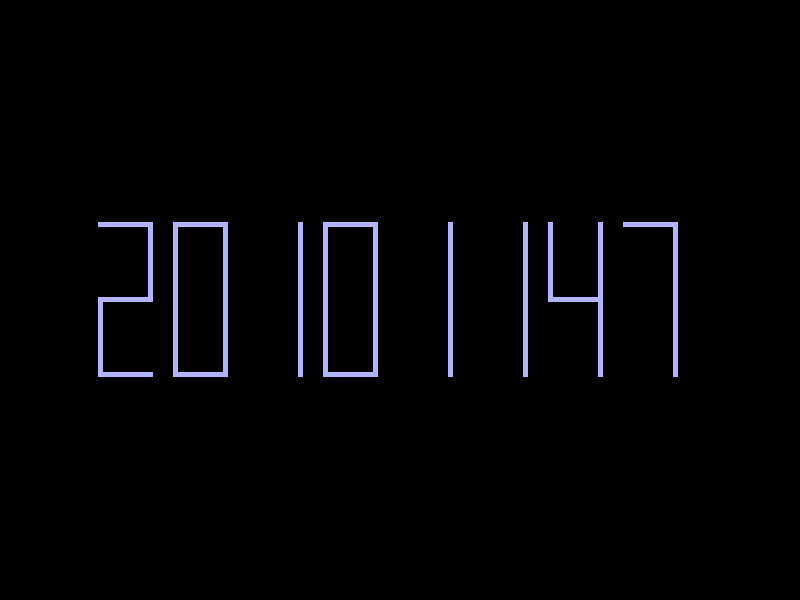

In [104]:
idprint(20101147)

img_buf = gl.glReadPixelsub(0, 0, WIDTH, HEIGHT, gl.GL_RGB, gl.GL_UNSIGNED_BYTE)
img = np.frombuffer(img_buf, np.uint8).reshape(HEIGHT, WIDTH, 3)[::-1]
show.image(img/255.0)